In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.text as plttext
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mc
from scipy.spatial import distance
from sklearn import datasets
from sklearn import metrics
from sklearn.preprocessing import minmax_scale,StandardScaler

import statistics as statics
import seaborn as sns

import time

In [ ]:
#data = np.array(pd.read_excel('pathbased.xlsx'))
data = np.array(pd.read_csv('checkboard.csv'))
#data =np.vstack([data,np.array([[0,-2.7],[-1,-1.1],[-2.5,1],[0,0.5],[2.5,-2.5],[-1,2.4],[2.5,3]])])
data = np.unique(data,axis=0)
databackup = data
data = minmax_scale(data[:,0:2])
plt.plot(data[:, 0], data[:, 1], 'b.')
N = len(data)

In [19]:
def mycluster (noise_threshold=1, use_center=False, denoise=False, text='' ):
  start_time = time.time()

  dist_matrix = distance.cdist(data, data, 'euclidean')
  for ii in range(N):
    dist_matrix[ii, ii] = np.inf
  min1 = dist_matrix.min(axis=1)
  meandist = np.mean(min1)
  std = np.std(min1)
  gridlength = min1.min(axis=0)

  if(denoise==True):
    z = (min1 - meandist)/std
    argoutliers = np.argwhere(z>3)
    finalnoises = argoutliers
    min1 = np.delete(min1,argoutliers, axis=0)

  maxmin = min1.max(axis=0)
  noiseradius = np.math.ceil((maxmin / gridlength)/2)

#noise_threshold = 85
  cluster_number = np.zeros((N, 1))
  added_to_neighbor = np.zeros((N,1))

  noise = []
  non_noise = []
  biglist = []
  for i in range(N):
    bli = np.argwhere((dist_matrix[i] / gridlength)/2 < noiseradius)
    if len(bli)< noise_threshold:
      noise.append(i)
      cluster_number[i] = -1
    else:
      non_noise.append(i)

    biglist.append( bli)

  noise = np.reshape(noise, (len(noise), 1))
  if len(noise)>0:
    noise_data = data[noise]
    noise_data = noise_data.reshape(len(noise_data),data.shape[1])
    non_noise_data =  data[non_noise] # np.delete(data, noise, axis=0)
  else:
    non_noise_data = data


#--------------------------------------------
  num_not_clustered = len(non_noise_data)
  non_noise_backup = non_noise
  index = np.random.randint(0, len(data))
  neighborlist = []
  clusters = [-1]
  current_cluster = 0


  while num_not_clustered > 0:
    current_cluster += 1
    gg = 0
    while cluster_number[index] in clusters:
      index = np.random.randint(0, len(data))

    clusters.append(current_cluster)
    neighborlist.append(index)
    cluster = []
    while len(neighborlist) > 0:
      index = neighborlist.pop(0)
      cluster_number[index] = current_cluster
      num_not_clustered -= 1
      #lstn = biglist[index] #np.argwhere(((dist_matrix[index,:] / gridlength)/2) < noiseradius)

      for j in range(len(biglist[index])):
        if cluster_number[biglist[index][j]] == 0:
          cluster_number[biglist[index][j]] = current_cluster
          if added_to_neighbor[biglist[index][j]]== 0:
            neighborlist.append(np.int(biglist[index][j,0]))
            added_to_neighbor[biglist[index][j]]= 1


  clusters.pop(0)

  if len(clusters) > 6:
    colors = np.zeros((len(clusters),3))
    for co in range(len(clusters)):
      colors[co] = np.random.rand(1,3)
  else:
    colors = ['green','magenta','cyan','blue','yellow','black']

  st = plttext.Text()
  cluster_centers = np.zeros((len(clusters),2))

  for i in range(len(clusters)):
    X = data[np.where(cluster_number == i+1)[0], 0]
    Y = data[np.where(cluster_number == i+1)[0], 1]
    cluster_centers[i,0] = statics.mean(X)
    cluster_centers[i,1] = statics.mean(Y)

  if use_center == True:
    for k  in range(len(noise)):
      dist_from_center =distance.cdist(data[noise[k]][0].reshape(1,len(data[noise[k]][0])), cluster_centers, 'euclidean')
      sortedneighbor = np.argmin(dist_from_center[0,:])
      cluster_number[noise[k]] = sortedneighbor+1

  else:
    for k  in range(len(cluster_number)):
      if cluster_number[k] == -1:
        sortedneighbor = np.argsort(dist_matrix[k,:])
        m = 0
        while  cluster_number[sortedneighbor[m]] ==-1:
          m += 1

        cluster_number[k] = cluster_number[sortedneighbor[m]]
    '''for k  in range(len(cluster_number)):
      if cluster_number[k] == -1:
        sortedneighbor = np.argsort(np.where(cluster_number[biglist[k][:]]!=-1))
        m = 0
        while  cluster_number[sortedneighbor[m]] ==-1:
          m += 1

        cluster_number[k] = cluster_number[sortedneighbor[m]]'''


  end_time = time.time()

  '''newdata = np.concatenate((data, cluster_number), axis=1)
  np.savetxt('checkboardnewdata.csv', newdata, delimiter=',')
  np.savetxt('cluster_number.csv',cluster_number, delimiter=',')'''

  #Silhouette Score
  for ii in range(N):
    dist_matrix[ii, ii] = 0

  '''sil = metrics.silhouette_score(data, cluster_number,metric='euclidean' )
  print(sil)
  calinski = metrics.calinski_harabasz_score(data, cluster_number)
  print(calinski)
  david = metrics.davies_bouldin_score(data, cluster_number)
  print(david)'''

  #RAND Index
  '''randindex = metrics.adjusted_rand_score((np.reshape(databackup[:,2],(1,len(databackup)))[0]), (np.reshape(cluster_number,(1,len(cluster_number))))[0])
  print(randindex)
  mutualinfo = metrics.adjusted_mutual_info_score((np.reshape(databackup[:,2],(1,len(databackup)))[0]), (np.reshape(cluster_number,(1,len(cluster_number))))[0])
  print(mutualinfo)
  homogeneity = metrics.homogeneity_score((np.reshape(databackup[:,2],(1,len(databackup)))[0]), (np.reshape(cluster_number,(1,len(cluster_number))))[0])
  print(homogeneity)
  fowlkes_mallows = metrics.fowlkes_mallows_score((np.reshape(databackup[:,2],(1,len(databackup)))[0]), (np.reshape(cluster_number,(1,len(cluster_number))))[0])
  print(fowlkes_mallows)'''

  if denoise==True:
    plt.plot(data[finalnoises[:,0],0],data[finalnoises[:,0],1],'r*',markersize="8")
    plt.legend(["Outliers"])
    datadenoised = np.delete(data,finalnoises, axis=0)
    clusternumberdenoised = np.delete(cluster_number,finalnoises,axis=0)

  for i in range(len(clusters)):
    if denoise==True:
      X = datadenoised[np.where(clusternumberdenoised == i+1)[0], 0]
      Y = datadenoised[np.where(clusternumberdenoised == i+1)[0], 1]
      #Z = datadenoised[np.where(clusternumberdenoised == i+1)[0], 2]
    else:
      X = data[np.where(cluster_number == i+1)[0], 0]
      Y = data[np.where(cluster_number == i+1)[0], 1]
      #Z = data[np.where(cluster_number == i+1)[0], 2]
    plt.plot(X, Y, marker='.', linestyle='', color=colors[i], markersize=5 )
    #plt.plot(cluster_centers[i,0], cluster_centers[i,1],marker=str(i), markersize=10, color='black')
    plt.text(cluster_centers[i,0], cluster_centers[i,1],str(i+1), color='red',ha="center", va="center",fontsize=12,fontweight='bold')

  plt.title(text)
  #plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
  print(end_time - start_time)



<ipython-input-19-edc3a5a718ab>:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  neighborlist.append(np.int(biglist[index][j,0]))


0.3452293872833252


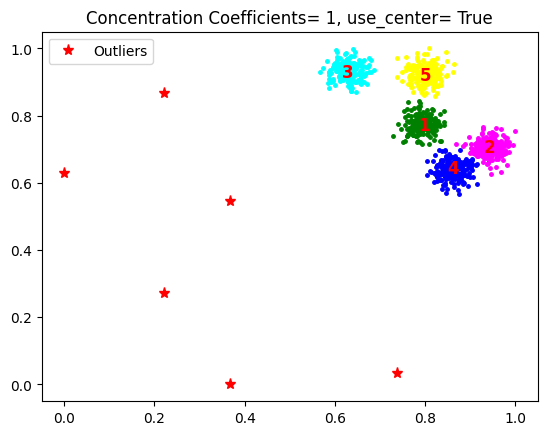

In [24]:
mycluster(noise_threshold= 50, use_center= True, denoise=True, text='Concentration Coefficients= 1, use_center= True')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Text(-0.5, 0.7, 'Clustering took 0.05 s')

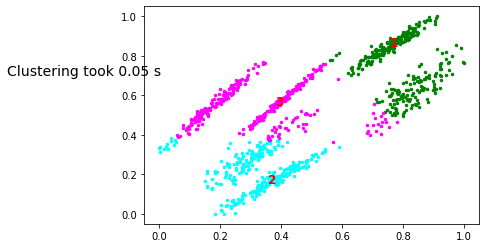

In [ ]:
start_time = time.time()

dist_matrix = distance.cdist(data, data, 'euclidean')
for ii in range(N):
  dist_matrix[ii, ii] = np.inf
min1 = dist_matrix.min(axis=1)
gridlength = min1.min(axis=0)
maxmin = min1.max(axis=0)
noiseradius = np.math.ceil((maxmin / gridlength)/2)

noise_threshold = 50
cluster_number = np.zeros((N, 1))
added_to_neighbor = np.zeros((N,1))

noise = []
non_noise = []
biglist = []
for i in range(N):
  bli = np.argwhere((dist_matrix[i] / gridlength)/2 < noiseradius)
  if len(bli)< noise_threshold:
    noise.append(i)
    cluster_number[i] = -1
  else:
    non_noise.append(i)

  biglist.append( bli)

noise = np.reshape(noise, (len(noise), 1))
if len(noise)>0:
  noise_data = data[noise]
  noise_data = noise_data.reshape(len(noise_data),data.shape[1])
  non_noise_data =  data[non_noise] # np.delete(data, noise, axis=0)
else:
  non_noise_data = data


#--------------------------------------------
num_not_clustered = len(non_noise_data)
non_noise_backup = non_noise
index = np.random.randint(0, len(data))
neighborlist = []
clusters = [-1]
current_cluster = 0


while num_not_clustered > 0:
  current_cluster += 1
  gg = 0
  while cluster_number[index] in clusters:
    index = np.random.randint(0, len(data))

  clusters.append(current_cluster)
  neighborlist.append(index)
  cluster = []
  while len(neighborlist) > 0:
    index = neighborlist.pop(0)
    cluster_number[index] = current_cluster
    num_not_clustered -= 1
    #lstn = biglist[index] #np.argwhere(((dist_matrix[index,:] / gridlength)/2) < noiseradius)

    for j in range(len(biglist[index])):
      if cluster_number[biglist[index][j]] == 0:
        cluster_number[biglist[index][j]] = current_cluster
        if added_to_neighbor[biglist[index][j]]== 0:
          neighborlist.append(np.int(biglist[index][j,0]))
          added_to_neighbor[biglist[index][j]]= 1




clusters.pop(0)

if len(clusters) > 6:
  colors = np.zeros((len(clusters),3))
  for co in range(len(clusters)):
    colors[co] = np.random.rand(1,3)
else:
  colors = ['green','cyan','magenta','blue','yellow','black']

st = plttext.Text()
cluster_centers = np.zeros((len(clusters),2))


for i in range(len(clusters)):
  X = data[np.where(cluster_number == i+1)[0], 0]
  Y = data[np.where(cluster_number == i+1)[0], 1]
  cluster_centers[i,0] = statics.mean(X)
  cluster_centers[i,1] = statics.mean(Y)


for k  in range(len(cluster_number)):
  if cluster_number[k] == -1:
    dist_from_center =distance.cdist(data[k].reshape(1,len(data[k])), cluster_centers, 'euclidean')
    sortedneighbor = np.argmin(dist_from_center[0,:])
    cluster_number[k] = sortedneighbor+1

'''wt = len(noise)
while wt >0:
  for k  in range(len(noise)):
    sortedneighbor = (np.argsort(cluster_number[biglist[k][:]]!=-1))
    if len(sortedneighbor[0]) > 0:
      cluster_number[k] = cluster_number[sortedneighbor[0][0]]
      wt = wt-1
    #m = 0
    #while  cluster_number[sortedneighbor[m]] ==-1:
      #m += 1

    #cluster_number[k] = cluster_number[sortedneighbor[m]]'''



end_time = time.time()

for i in range(len(clusters)):
  X = data[np.where(cluster_number == i+1)[0], 0]
  Y = data[np.where(cluster_number == i+1)[0], 1]
  plt.plot(X, Y, marker='.', linestyle='', color=colors[i], markersize=5 )
    #plt.plot(cluster_centers[i,0], cluster_centers[i,1],marker=str(i), markersize=10, color='black')
  plt.text(cluster_centers[i,0], cluster_centers[i,1],str(i+1), color='red',ha="center", va="center",fontsize=12,fontweight='bold')


plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

In [ ]:
dist_matrix

In [ ]:
min1

In [ ]:
np.where(cluster_number[biglist[0][:]]==-1)

In [ ]:
np.argsort(np.where(cluster_number[biglist[0][:]]==-1))

In [ ]:
'''if use_center == True :
    for i in range(len(clusters)):
      X = data[np.where(cluster_number == i+1)[0], 0]
      Y = data[np.where(cluster_number == i+1)[0], 1]
      cluster_centers[i,0] = statics.mean(X)
      cluster_centers[i,1] = statics.mean(Y)
    #plt.plot(X, Y, color=colors[i]  ,marker='.' ,linestyle='', markersize=5)
    #plt.plot(X, Y, color=colors[i]  ,marker='.' ,linestyle='', markersize=5, label="C {}".format(i+1))
    #plt.plot(cluster_centers[i,0], cluster_centers[i,1],str(i), markersize=10, color='black')
    #plt.text(cluster_centers[i,0], cluster_centers[i,1],str(i+1), color='red',ha="center", va="center",fontsize=12,fontweight='bold')

    for k  in range(len(cluster_number)):
      if cluster_number[k] == -1:
        dist_from_center =distance.cdist(data[k].reshape(1,len(data[k])), cluster_centers, 'euclidean')
        sortedneighbor = np.argmin(dist_from_center[0,:])
        cluster_number[k] = sortedneighbor+1
  else:
    for k  in range(len(cluster_number)):
      if cluster_number[k] == -1:
        sortedneighbor = np.argsort(dist_matrix[k,:])
        m = 0
        while  cluster_number[sortedneighbor[m]] ==-1:
          m += 1

      cluster_number[k] = cluster_number[sortedneighbor[m]]'''

In [ ]:
#Silhouette Score
for ii in range(N):
  dist_matrix[ii, ii] = 0

sil = metrics.silhouette_score(dist_matrix, cluster_number,metric='euclidean', sample_size=None )
print(sil)
pp = metrics.silhouette_samples(dist_matrix, cluster_number,metric='euclidean')
print(pp)

In [ ]:
#Homogeneity score
lbl = np.zeros(1500)
pred = np.zeros(1500)
for tt  in range(N):
  lbl[tt] = np.math.floor((tt/500))+1
  pred[tt] = cluster_number[tt,0]

homo = metrics.homogeneity_score(lbl,pred)
print(homo)
del cluster_number,pred,lbl

In [ ]:
from sklearn.metrics import davies_bouldin_score
print(davies_bouldin_score(data, cluster_number))